In [1]:
!git clone https://github.com/ivandonofrio/recovery_fund_analysis.git

Cloning into 'recovery_fund_analysis'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 3), reused 22 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [2]:
!pip3 install treetaggerwrapper
!pip3 install transformers

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for treetaggerwrapper: filename=treetaggerwrapper-2.3-cp36-none-any.whl size=40772 sha256=1e9763be570a3dd28a19c71713eedd9e28093eb5b6742566e0ebb6ecb0d71909
  Stored in directory: /root/.cache/pip/wheels/46/64/50/b1944d17fbf5b2882438a50bb37b3d9549443ef29e121b9a38
Successfully built treetaggerwrapper
     |████████████████████████████████| 1.1MB 5.7MB/s 
     |████████████████████████████████| 890kB 24.4MB/s 
     |████████████████████████████████| 1.1MB 44.3MB/s 
     |████████████████████████████████| 3.0MB 53.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d046c090d3ba20a6565c9450bc95c09cc627126e833ac82f36fdc3cb874f3312
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
!mkdir frequencies
!mkdir datasets

In [4]:
%%shell
cd recovery_fund_analysis/treetagger
sh install-tagger.sh


TreeTagger version for PC-Linux installed.
Tagging scripts installed.
Italian parameter file installed.
Path variables modified in tagging scripts.

You might want to add /content/recovery_fund_analysis/treetagger/cmd and /content/recovery_fund_analysis/treetagger/bin to the PATH variable so that you do not need to specify the full path to run the tagging scripts.



In [5]:
import re
import io
import spacy
import string
from operator import itemgetter

import pandas as pd
import numpy as np

from tqdm import tqdm, trange

import nltk
import treetaggerwrapper
from nltk import bigrams, FreqDist
from nltk.tokenize import RegexpTokenizer

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

import torch
from transformers import BertTokenizer, BertConfig, BertModel

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.cluster.hierarchy import dendrogram

In [6]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data Exploration

## Lemmatizer

In [7]:
class Lemmatizer:

  def __init__(self):

    self.tagger = treetaggerwrapper.TreeTagger(
        TAGLANG='it', 
        TAGDIR='recovery_fund_analysis/treetagger'
    )

  def __call__(self, text):

    tags = self.tagger.tag_text(text)
    tags = treetaggerwrapper.make_tags(tags)

    return " ".join([tag[2] for tag in tags if len(tag) > 2])

## Load Dataset

In [8]:
# Convert "Costo" value string to billions
def convert_value(string_value):

  string_value = str(string_value)
  string_value = string_value.replace("€", "").strip()
  string_value = string_value.replace(".", "").split(",")[0]

  return int(string_value)/1000000000

# Remove useless spaces or new lines from document titles
def clean_title(title):

  title = re.sub(r'\s|\W', ' ', title)
  return title

In [9]:
# Load Recovery Fund dataset
recovery_fund = pd.read_csv("recovery_fund_analysis/dataset/recovery_fund.tsv", sep="\t")
recovery_fund

,Nr.,Titolo progetto PNRR,Amministrazione\rproponente,Costo,Durata,Obiettivo / Motivazione,Macroarea,Nome file,Tipologia progetto,Unnamed: 9
0,2.0,#SCUOLEFUTURE – Programma di trasformazione di...,Ministero dell'Istruzione,"2.688.000.000,00",3 anni,L’obiettivo del programma è la transizione al ...,Costruire e ristrutturare,Cofinanziati MEF,Investimento,NaN
1,5.0,EDUCATION FOR ALL - Inclusione e coesione soci...,Ministero dell'Istruzione,"55.000.000,00",4 anni,La proposta progettuale ha come obiettivo quel...,Costruire e ristrutturare,Cofinanziati MEF,Riforma,NaN
2,6.0,Sistem@ITSItalia: sistema di istruzione terzia...,Ministero dell'Istruzione,"2.250.637.840,00",5 anni,Il progetto Sistem@ITSItalia si articola in ot...,Costruire e ristrutturare,Cofinanziati MEF,Riforma,NaN
3,7.0,“European classroom”: modernizzare i sistemi d...,Ministero dell'Istruzione,"400.000.000,00",6 anni,Dati gli obiettivi sopra indicati che sono in ...,Costruire e ristrutturare,Cofinanziati MEF,Riforma,NaN
4,133.0,Cofinanziamento per lo sviluppo dei servizi ed...,PCM-Dipartimento per le\rpolitiche della famiglia,"2.881.465.000,00",5 anni,Il progetto ha come obiettivo generale di prom...,Costruire e ristrutturare,Cofinanziati MEF,Investimento,NaN
...,...,...,...,...,...,...,...,...,...,...
401,650.0,Smart of Things as-a-service,Sogei s.p.a,"3.000.000,00 €",3 anni,Sviluppo di una piattaforma digitale abilitant...,Industria sostenibile,RPT stampa,NaN,NaN
402,656.0,Digitale per tutti,Ministro per l'Innovazione tecnologica e la Di...,"5.000.000.000,00 €",3 anni,La proposta ha l'obiettivo di consentire nel t...,NaN,RPT stampa,NaN,NaN
403,669.0,Attrazione di investimenti per l􏰅innovazione d...,Ministro per l'Innovazione tecnologica e la Di...,"5.000.000.000,00 €",7 anni,L'obiettivo è sviluppare in italia il comparto...,Costruire e ristrutturare,RPT stampa,NaN,NaN
404,676.0,Sviluppo delle infrastrutture digitali del Paese,Ministro per l'Innovazione tecnologica e la Di...,"5.000.000.000,00 €",5 anni,Sviluppare le infrastrutture digitali del Paes...,Costruire e ristrutturare,RPT stampa,NaN,NaN


In [10]:
recovery_fund.to_json("prova.json", orient="records")

In [11]:
# Change columns names
columns = [
  "Nr.",
  "Titolo progetto PNRR",
  "Amministrazione proponente",
  "Costo",
  "Durata",
  "Obiettivo / Motivazione",
  "Macroarea",
  "Nome file",
  "Tipologia progetto",
  "Last column"
]

recovery_fund.columns = columns
recovery_fund.count(axis=0)[columns[:9]].to_csv("datasets/count_not_null.csv")

# Preserve only valid columns
recovery_fund = recovery_fund[recovery_fund["Obiettivo / Motivazione"].notna()]
recovery_fund = recovery_fund[recovery_fund["Costo"].notna()]

# Clean costs, titles and sentences
recovery_fund["Costo"] = recovery_fund["Costo"].map(convert_value)
recovery_fund["Amministrazione proponente"] = recovery_fund["Amministrazione proponente"].map(clean_title)
recovery_fund["Titolo progetto PNRR"] = recovery_fund["Titolo progetto PNRR"].map(clean_title)

# Remove "In elaborazione" rows
recovery_fund = recovery_fund[recovery_fund.apply(lambda x: len(x["Obiettivo / Motivazione"].split()) > 4, axis=1)]

# Total of money by macroarea and store total number of money by macro-area
sum_of_money = recovery_fund.copy()
sum_of_money.loc[sum_of_money["Macroarea"].isna(), "Macroarea"] = "Non valorizzato"
sum_of_money["Macroarea"] = sum_of_money["Macroarea"].map(clean_title).str.lower().str.strip().str.capitalize()
sum_of_money.groupby("Macroarea").sum("Costo").to_csv("datasets/cost_by_macroarea.csv")

# Preserve only interesting columns
recovery_fund = recovery_fund[[
  "Titolo progetto PNRR", 
  "Amministrazione proponente",
  "Costo",
  "Obiettivo / Motivazione",
]]

recovery_fund = recovery_fund.reset_index(drop=True)
recovery_fund

,Titolo progetto PNRR,Amministrazione proponente,Costo,Obiettivo / Motivazione
0,SCUOLEFUTURE Programma di trasformazione di...,Ministero dell Istruzione,2.688000,L’obiettivo del programma è la transizione al ...
1,EDUCATION FOR ALL Inclusione e coesione soci...,Ministero dell Istruzione,0.055000,La proposta progettuale ha come obiettivo quel...
2,Sistem ITSItalia sistema di istruzione terzia...,Ministero dell Istruzione,2.250638,Il progetto Sistem@ITSItalia si articola in ot...
3,European classroom modernizzare i sistemi d...,Ministero dell Istruzione,0.400000,Dati gli obiettivi sopra indicati che sono in ...
4,Cofinanziamento per lo sviluppo dei servizi ed...,PCM Dipartimento per le politiche della famiglia,2.881465,Il progetto ha come obiettivo generale di prom...
...,...,...,...,...
390,Smart of Things as a service,Sogei s p a,0.003000,Sviluppo di una piattaforma digitale abilitant...
391,Digitale per tutti,Ministro per l Innovazione tecnologica e la Di...,5.000000,La proposta ha l'obiettivo di consentire nel t...
392,Attrazione di investimenti per l innovazione d...,Ministro per l Innovazione tecnologica e la Di...,5.000000,L'obiettivo è sviluppare in italia il comparto...
393,Sviluppo delle infrastrutture digitali del Paese,Ministro per l Innovazione tecnologica e la Di...,5.000000,Sviluppare le infrastrutture digitali del Paes...


In [12]:
# Show that every column has not NaN columns 
recovery_fund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Titolo progetto PNRR        395 non-null    object 
 1   Amministrazione proponente  395 non-null    object 
 2   Costo                       395 non-null    float64
 3   Obiettivo / Motivazione     395 non-null    object 
dtypes: float64(1), object(3)
memory usage: 12.5+ KB


## Store text

In [13]:
text = recovery_fund["Obiettivo / Motivazione"]

# Encoding and Feature Extraction

## Stopwords

In [14]:
# Get italian stopwords
stopwords = nltk.corpus.stopwords.words("italian")

In [15]:
# Choose words to be preserved
preserve_words = [
  'ambientale',
  'ambito',
  'formativo',
  'impatto',
  'sanitario',
  'territorio',
  'sicurezza',
  'tecnologia',
  'tecnologico',
  'sostenibile',
  'scuola',
  'infrastruttura',
  'informatico',
  'prevenzione',
  'impresa',
  'formazione',
  'digitalizzazione',
  'amministrativo',
  'culturale',
  'comunicazione',
  'amministrazione'
]

In [16]:
# Tokenize every text in order to get all tokens collection
lemmatizer = Lemmatizer()
tokens = []

for sentence in text:
  tokens += [token.lower() 
             for token in nltk.word_tokenize(lemmatizer(sentence))
             if token.lower() not in stopwords 
             and len(token) > 1 
             and token not in string.punctuation
             and token != "``"]

In [17]:
# Find most frequent tokens and add them to stopwords collection
frequencies = nltk.FreqDist(tokens)
common_words = [word for word, freq in frequencies.most_common(200)]

In [18]:
# Generate new stopwords set, enriched by most frequent words and lemmatized ones
lemmatized_stopwords = [lemmatizer(word) for word in stopwords]
enriched_stopwords = set(stopwords + lemmatized_stopwords + common_words + ["@card@"])

In [19]:
# Remove from stopwords tokens to be preserved
enriched_stopwords = enriched_stopwords.difference(preserve_words)

## Use BERT to perform text encoding

In [20]:
# Import BERT model and tokenizer pre-trained on italian language
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-italian-cased", do_lower_case=False)
model = BertModel.from_pretrained("dbmdz/bert-base-italian-cased", output_hidden_states=True)

In [21]:
# Send model to GPU in order to perform faster evaluation
model.cuda().eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31102, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [22]:
# Initialize embeddings collection in order to store 
text_embeddings = []

# Encode sentences using bert
for sentence in text:

  # Add the BERT special tokens
  marked_text = "[CLS] " + sentence + " [SEP]"

  # Split the sentence into tokens.
  tokenized_text = tokenizer.tokenize(marked_text)
  segments_ids = [1] * len(tokenized_text)

  # Map the token strings to their vocabulary indeces
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

  # Convert lists to tensors
  tokens_tensor = torch.tensor([indexed_tokens]).cuda()
  segments_tensors = torch.tensor([segments_ids]).cuda()

  with torch.no_grad():

    if len(indexed_tokens) > 512:

      tokens_tensor = torch.tensor([indexed_tokens[:512]]).cuda()
      segments_tensors = torch.tensor([segments_ids[:512]]).cuda()

    # Perform encoding with bert
    outputs = model(tokens_tensor, segments_tensors)

    # Store hidden states and preserve after concatenating last four layers output
    # Sentence embedding as mean of words encoding
    hidden_states = outputs[2]
    words_encoding = torch.cat((
        hidden_states[-1][0], 
        hidden_states[-2][0], 
        hidden_states[-3][0], 
        hidden_states[-4][0]), dim=1)
    
    sentence_embedding = torch.mean(words_encoding, dim=0)

  text_embeddings.append(sentence_embedding.detach().cpu().numpy())

In [23]:
text_embeddings[0].shape

(3072,)

# Hierarchical Clustering

In [24]:
twelve_clusters = {
    0: "Digitalizzazione Amministrazione Pubblica",
    1: "Formazione professionale",
    2: "Sicurezza",
    3: "Infrastrutture digitali",
    4: "Pari opportunità",
    5: "Farnesina e Affari Esteri",
    6: "Potenziamento SSN",
    7: "Territorio e Ambiente",
    8: "Adeguamento informatico Pubblica Amministrazione",
    9: "Riqualificazione infrastrutture",
    10: "Accessibilità Digitale",
    11: "Adeguamento informatico didattica"
}

six_clusters = {
    0: "Emergenza sanitaria",
    1: "Pubblica Amministrazione",
    2: "Infrastrutture",
    3: "Territorio e Ambiente",
    4: "Pari opportunità",
    5: "Formazione"
}

two_clusters = {
    0: "Sfera pubblica",
    1: "Sfera privata"
}

In [25]:
# Remove from sentence collection not valid monograms or bigrams
def validate_token(token, stopwords):

  if len(token) > 2 and token not in stopwords:
    if len(token.split()) < 2:
      return True
    else:
      if token.split()[0] in stopwords and token.split()[1] in stopwords:
        return False
      else:
        if (token.split()[0] in stopwords and len(token.split()[0])) < 3 or (token.split()[1] in stopwords and len(token.split()[1])):
          return False
        else:
          return True

  return False

In [26]:
# Plot dendrogram
def plot_dendrogram(model, **kwargs):
  
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [27]:
# Perform Hierarchical Clustering on sentence embeddings
clustering = AgglomerativeClustering(n_clusters=None, memory="./tree", compute_full_tree=True, distance_threshold=.2)
_ = clustering.fit(text_embeddings)

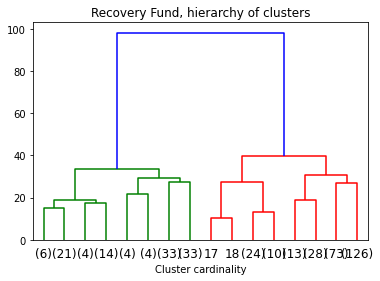

In [28]:
# Visualize hierarchy dendrogram with cluster cardinality
plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.title("Recovery Fund, hierarchy of clusters")
plt.xlabel("Cluster cardinality")
plt.show()

In [29]:
# Make a copy of Recovery Fund data for visualization
hierarchy_data = recovery_fund.copy()

# Find last twelve clusters hierarchy levels in order to make the visualization
for c in range(2, 13):

  clustering_post = AgglomerativeClustering(n_clusters=c)
  post_labels = clustering_post.fit_predict(text_embeddings)

  if c < 12:
    hierarchy_data[f"Labels_{c}"] = [f"cluster_{c}_{label}" for label in post_labels]
  else:
    hierarchy_data[f"Labels_{c}"] = post_labels

# Store hierarchy as csv
hierarchy_data["Labels_12"] = hierarchy_data["Labels_12"].map(twelve_clusters)
hierarchy_data[hierarchy_data.columns[-11:]].to_csv("datasets/cluster_hierarchy.csv")

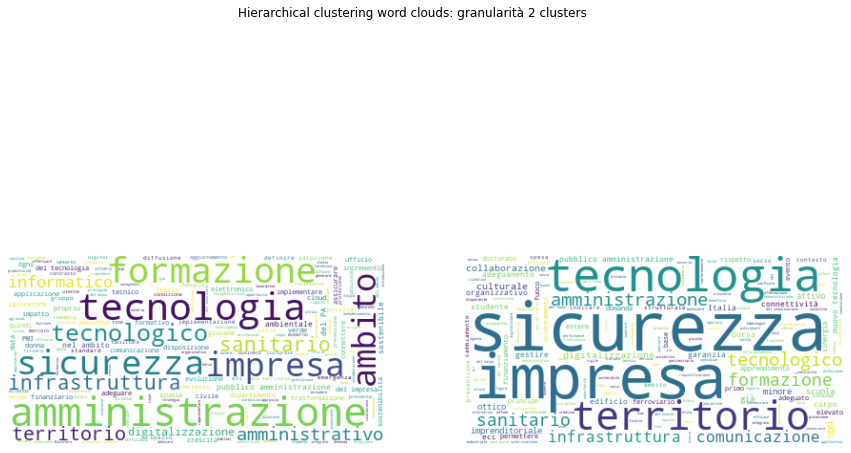

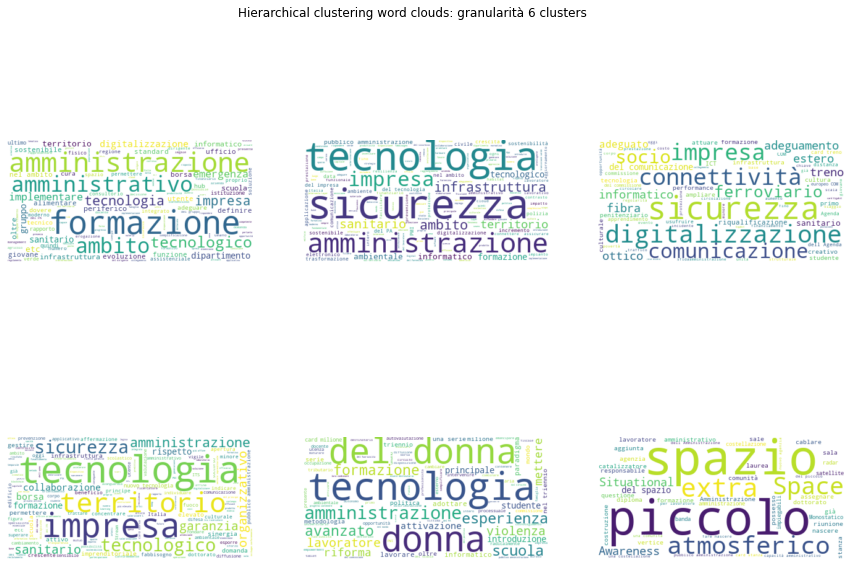

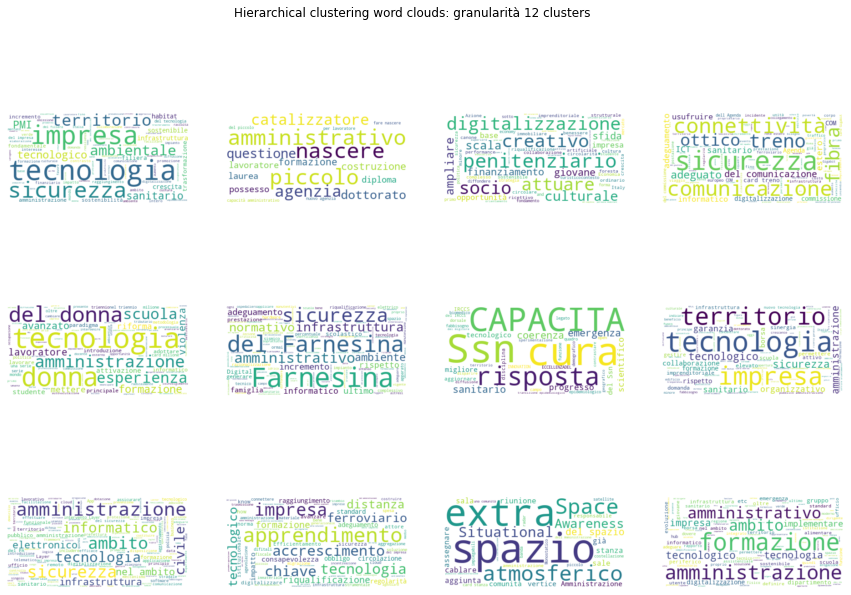

In [30]:
# Make a copy of Recovery Fund data for enrichment
cluster_data = recovery_fund.copy()
plot_grids = [(1, 2), (2, 3), (3, 4)]
cluster_names = [two_clusters, six_clusters, twelve_clusters]

# Extract only second, sixth and twelfth hierarchy level
for c, grid, titles in zip([2, 6, 12], plot_grids, cluster_names):

  # Extract cluster and store labels
  clustering = AgglomerativeClustering(n_clusters=c)
  labels = clustering.fit_predict(text_embeddings)
  cluster_data[f"Labels_{c}"] = labels

  # Generate plotgrid
  fig, ax = plt.subplots(*grid, figsize=(15,10))
  rows, cols = grid

  # Extract word clouds from clusters
  for index, label in enumerate(np.unique(cluster_data[f"Labels_{c}"])):

    # Get total text to be analyzed
    text = " ".join(cluster_data[cluster_data[f"Labels_{c}"] == label]["Obiettivo / Motivazione"].map(lemmatizer))

    # Extract monogram end bigram frequencies from text as dictionary
    tokenizer = RegexpTokenizer(r'\w+')
    sent_words = tokenizer.tokenize(text)
    freq_monogram = FreqDist(sent_words)
    freq_bigram = FreqDist(bigrams(sent_words))
    dict_monogram = dict(freq_monogram)
    dict_bigram = {" ".join(k):v for k, v in dict(freq_bigram).items()}
    dict_token = {**dict_monogram, **dict_bigram}

    # Get only valid words and remove stopwords, storing the frequencies for analysis
    clean_dict = {k:v for k, v in dict_token.items() if validate_token(k, enriched_stopwords)}
    freq_df = pd.DataFrame([(k, v) for k, v in clean_dict.items()], columns=["ngram", "freq"]).nlargest(100, ['freq'])
    freq_df.to_csv(f"frequencies/frequencies_{c}_{label}.csv")

    # Generat and plot the word cloud
    wordcloud = WordCloud(stopwords=enriched_stopwords, background_color="white").generate_from_frequencies(clean_dict)

    if c == 2:
      ax[index%c].imshow(wordcloud, interpolation='bilinear')
      ax[index%c].axis("off")
    else:
      ax[index//cols][index%cols].imshow(wordcloud, interpolation='bilinear')
      ax[index//cols][index%cols].axis("off")

  fig.suptitle(f"Hierarchical clustering word clouds: granularità {c} clusters")
  plt.show()

# Set cluster names for visualizations
cluster_data["Labels_2"] = cluster_data["Labels_2"].map(two_clusters)
cluster_data["Labels_6"] = cluster_data["Labels_6"].map(six_clusters)
cluster_data["Labels_12"] = cluster_data["Labels_12"].map(twelve_clusters)

# Export dataset
cluster_data[["Costo", "Labels_2", "Labels_6", "Labels_12"]].to_csv("datasets/clustering_output.csv")

In [31]:
# Apply PCA in order to visualize clusters in two dimensions
pca = PCA(n_components=2).fit_transform(text_embeddings)
components = pd.DataFrame(pca, columns=["Prima componente principale", "Seconda componente principale"])
components[["Labels_2", "Labels_6", "Labels_12"]] = cluster_data[["Labels_2", "Labels_6", "Labels_12"]].values

# Export PCA dataset as csv
components.to_csv("principal_components.csv")